# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

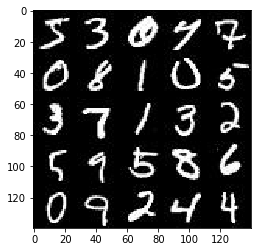

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

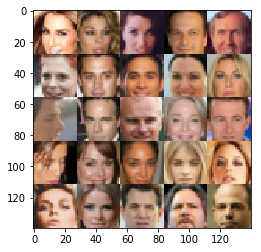

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


C:\ProgramData\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = "real_image")
    z_image = tf.placeholder(tf.float32, [None, z_dim], name = "z_image")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate")
    
    return real_image, z_image, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse = reuse):
        # 28*28
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = "same")
        relu1 = tf.maximum(alpha*x1, x1)
        
        # 14*14
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = "same")
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        
        # Flaten the image
        flaten = tf.reshape(relu2, (-1, 7*7*128))
        logist = tf.layers.dense(flaten, 1)
        output = tf.sigmoid(logist)

    return output, logist


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse = not is_train):
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*128)
        
        # Reshape it to an image
        x1 = tf.reshape(x1, (-1, 7, 7, 128))
        bn1 = tf.layers.batch_normalization(x1, training = is_train)
        relu1 = tf.maximum(bn1*alpha, bn1)
        
        # 7*7*128
        x2 = tf.layers.conv2d_transpose(relu1, 64, 5, strides = 2, padding = "same")
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(bn2*alpha, bn2)
        
        # 14*14*64
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides = 2, padding = "same")
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    real_image, z_image, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_image, z_image, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={real_image: batch_images, z_image: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={z_image: batch_z, lr:learning_rate})
                
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_image: batch_z, real_image: batch_images})
                    train_loss_g = g_loss.eval({z_image: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 10, z_image, data_shape[3],  data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.1159
Epoch 1/2... Discriminator Loss: 0.5395... Generator Loss: 1.8573
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 1.5830
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 0.7749... Generator Loss: 1.3426
Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 0.5606
Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 1.5865
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 1.5377
Epoch 1/2... Discriminator Loss: 0.6630... Generator Loss: 1.5179
Epoch 1/2... Discriminator Loss: 0.6124... Generator Loss: 1.8228


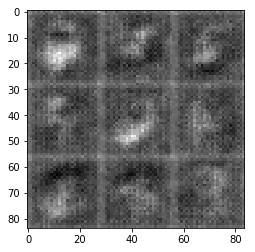

Epoch 1/2... Discriminator Loss: 0.6212... Generator Loss: 1.9001
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 2.2806
Epoch 1/2... Discriminator Loss: 0.6332... Generator Loss: 1.6164
Epoch 1/2... Discriminator Loss: 0.7810... Generator Loss: 1.1520
Epoch 1/2... Discriminator Loss: 0.7547... Generator Loss: 1.7150
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 1.0005
Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 2.1453


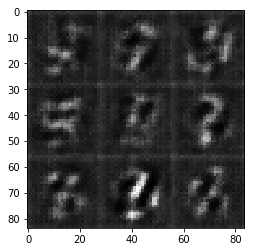

Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.5433
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.0944... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 0.8424... Generator Loss: 2.0227
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.0916
Epoch 1/2... Discriminator Loss: 0.9213... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 0.8541... Generator Loss: 1.4325


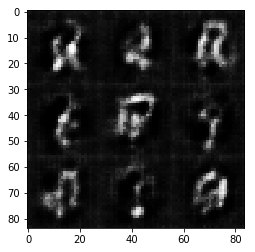

Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.6645
Epoch 1/2... Discriminator Loss: 0.9605... Generator Loss: 0.9149
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.6057
Epoch 1/2... Discriminator Loss: 0.8061... Generator Loss: 1.4625
Epoch 1/2... Discriminator Loss: 0.9058... Generator Loss: 1.3980
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.3896
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 1.3000
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.4020
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.3424
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 1.0598


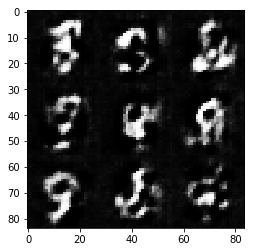

Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 1.4284
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 1.5214
Epoch 1/2... Discriminator Loss: 1.0463... Generator Loss: 1.9882
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 0.7353... Generator Loss: 1.5274
Epoch 1/2... Discriminator Loss: 0.8557... Generator Loss: 1.6924
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 0.9494
Epoch 1/2... Discriminator Loss: 0.7118... Generator Loss: 1.4439
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 1.4596
Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 1.4305


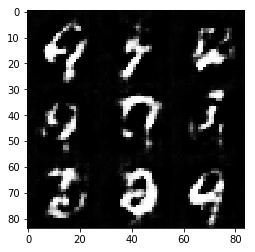

Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 1.8956
Epoch 1/2... Discriminator Loss: 0.8531... Generator Loss: 1.1653
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.7953
Epoch 1/2... Discriminator Loss: 0.7275... Generator Loss: 1.5081
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.5775
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.4003
Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 0.9833
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 1.2257
Epoch 1/2... Discriminator Loss: 0.7395... Generator Loss: 1.5657
Epoch 1/2... Discriminator Loss: 0.7229... Generator Loss: 1.6986


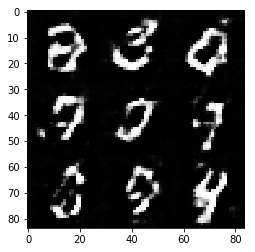

Epoch 1/2... Discriminator Loss: 0.8712... Generator Loss: 1.0608
Epoch 1/2... Discriminator Loss: 0.7432... Generator Loss: 1.4530
Epoch 1/2... Discriminator Loss: 0.8600... Generator Loss: 1.0466
Epoch 1/2... Discriminator Loss: 0.7447... Generator Loss: 1.4074
Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 0.9803
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.7275
Epoch 1/2... Discriminator Loss: 0.8359... Generator Loss: 1.1325
Epoch 1/2... Discriminator Loss: 0.9351... Generator Loss: 1.0680
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.5748
Epoch 1/2... Discriminator Loss: 0.7522... Generator Loss: 1.3647


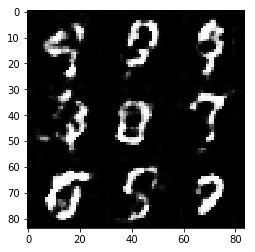

Epoch 1/2... Discriminator Loss: 1.0541... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 0.7393... Generator Loss: 1.3018
Epoch 1/2... Discriminator Loss: 0.7916... Generator Loss: 1.3986
Epoch 1/2... Discriminator Loss: 0.6850... Generator Loss: 1.6461
Epoch 1/2... Discriminator Loss: 0.7227... Generator Loss: 1.7801
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 1.7855
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.3879
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.0238
Epoch 1/2... Discriminator Loss: 0.8025... Generator Loss: 1.3009
Epoch 1/2... Discriminator Loss: 0.7882... Generator Loss: 1.2001


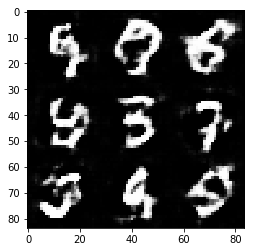

Epoch 1/2... Discriminator Loss: 0.6742... Generator Loss: 1.8618
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.7347... Generator Loss: 1.7350
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 2.1573
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 1.3933
Epoch 1/2... Discriminator Loss: 1.0724... Generator Loss: 0.8317
Epoch 1/2... Discriminator Loss: 0.9234... Generator Loss: 1.9775
Epoch 1/2... Discriminator Loss: 0.7224... Generator Loss: 2.1179
Epoch 1/2... Discriminator Loss: 0.8224... Generator Loss: 1.6569
Epoch 1/2... Discriminator Loss: 0.7653... Generator Loss: 1.4693


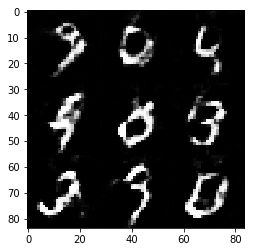

Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.8301
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 1.6870
Epoch 1/2... Discriminator Loss: 0.8431... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 0.8218... Generator Loss: 1.4983
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.5422
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.6157
Epoch 2/2... Discriminator Loss: 0.8376... Generator Loss: 1.4696
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 0.9150... Generator Loss: 1.9534
Epoch 2/2... Discriminator Loss: 0.8103... Generator Loss: 1.6860


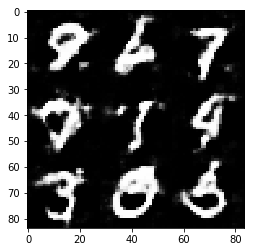

Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 1.5116
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.7085
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.5826
Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 1.1925
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.7724
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 0.8217... Generator Loss: 1.4634
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.4175
Epoch 2/2... Discriminator Loss: 0.8688... Generator Loss: 1.1856
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 1.1709


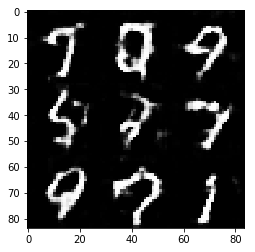

Epoch 2/2... Discriminator Loss: 0.6348... Generator Loss: 2.0222
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.8368... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 0.7449... Generator Loss: 1.8198
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.8201
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.4052
Epoch 2/2... Discriminator Loss: 0.7701... Generator Loss: 1.5187
Epoch 2/2... Discriminator Loss: 1.2039... Generator Loss: 0.6676
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.8462
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 1.0381


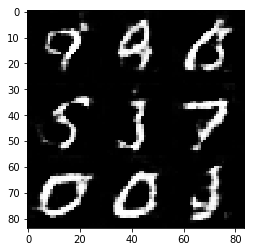

Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.7595
Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.5826
Epoch 2/2... Discriminator Loss: 1.0189... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 0.8203... Generator Loss: 1.3574
Epoch 2/2... Discriminator Loss: 1.3432... Generator Loss: 2.5710
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.2441
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 0.9989
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.7365
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.7452


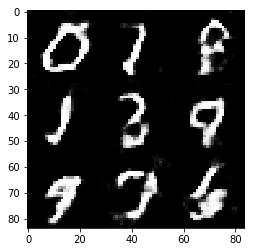

Epoch 2/2... Discriminator Loss: 0.8328... Generator Loss: 1.3268
Epoch 2/2... Discriminator Loss: 1.1069... Generator Loss: 1.5782
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.4447
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.6488
Epoch 2/2... Discriminator Loss: 0.9668... Generator Loss: 1.5980
Epoch 2/2... Discriminator Loss: 1.0043... Generator Loss: 0.8102
Epoch 2/2... Discriminator Loss: 0.8209... Generator Loss: 1.6942
Epoch 2/2... Discriminator Loss: 0.8065... Generator Loss: 1.1950
Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.8307
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.4535


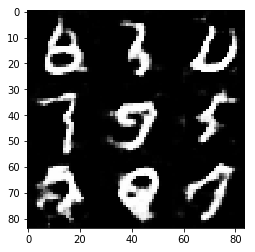

Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 1.8291
Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.4450
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 1.2967
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 0.7762
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.3909
Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 1.4533
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 0.8893... Generator Loss: 1.1843


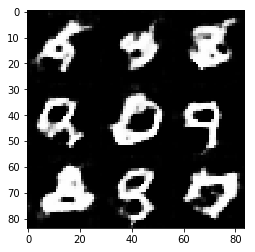

Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 0.9873
Epoch 2/2... Discriminator Loss: 0.8104... Generator Loss: 1.6037
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.4303
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.3332
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 2.3633
Epoch 2/2... Discriminator Loss: 0.8534... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 0.8993... Generator Loss: 1.6827
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.7481


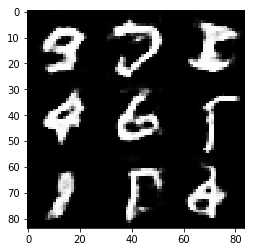

Epoch 2/2... Discriminator Loss: 0.9341... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.5363
Epoch 2/2... Discriminator Loss: 0.8593... Generator Loss: 1.1427
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 1.0612
Epoch 2/2... Discriminator Loss: 0.8707... Generator Loss: 1.1759
Epoch 2/2... Discriminator Loss: 0.7041... Generator Loss: 1.9357
Epoch 2/2... Discriminator Loss: 0.7657... Generator Loss: 1.4612
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 2.2148
Epoch 2/2... Discriminator Loss: 0.8563... Generator Loss: 1.0412
Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.3983


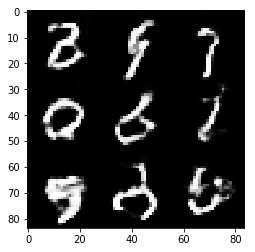

Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.6052
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 0.8952... Generator Loss: 1.0595
Epoch 2/2... Discriminator Loss: 0.8185... Generator Loss: 1.3312
Epoch 2/2... Discriminator Loss: 0.9916... Generator Loss: 2.3292
Epoch 2/2... Discriminator Loss: 0.7585... Generator Loss: 1.5938
Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 1.5807
Epoch 2/2... Discriminator Loss: 0.8519... Generator Loss: 1.1850
Epoch 2/2... Discriminator Loss: 0.6292... Generator Loss: 1.6937
Epoch 2/2... Discriminator Loss: 1.3925... Generator Loss: 0.5700


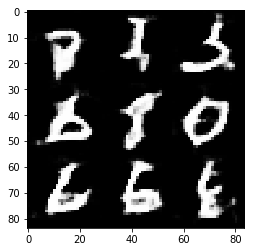

Epoch 2/2... Discriminator Loss: 0.9611... Generator Loss: 1.2036
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 1.0282
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.4525
Epoch 2/2... Discriminator Loss: 0.7782... Generator Loss: 1.4672
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 0.9249
Epoch 2/2... Discriminator Loss: 0.7726... Generator Loss: 1.8569
Epoch 2/2... Discriminator Loss: 0.7288... Generator Loss: 1.6005


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.2300
Epoch 1/1... Discriminator Loss: 0.7553... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 0.6504... Generator Loss: 1.7625
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.1075
Epoch 1/1... Discriminator Loss: 0.5621... Generator Loss: 2.1789
Epoch 1/1... Discriminator Loss: 0.4853... Generator Loss: 2.6322
Epoch 1/1... Discriminator Loss: 0.5791... Generator Loss: 2.6071
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.8808
Epoch 1/1... Discriminator Loss: 0.7969... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.7046


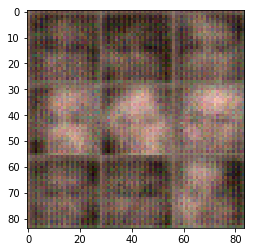

Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.4120
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.1426
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 0.9947... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 1.3475
Epoch 1/1... Discriminator Loss: 0.8345... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 0.9360... Generator Loss: 2.1750
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9188
Epoch 1/1... Discriminator Loss: 0.8700... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8751


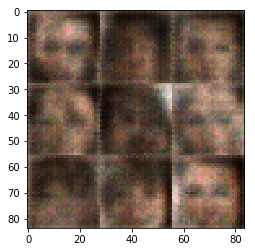

Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.1758
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.4920
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.3036
Epoch 1/1... Discriminator Loss: 0.9837... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.9487
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 1.1645
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.8236


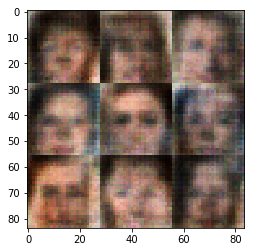

Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.0175... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 1.0299... Generator Loss: 1.2043
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 1.4290
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 1.1448


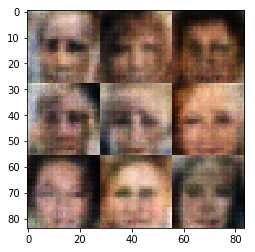

Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.3426
Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0490
Epoch 1/1... Discriminator Loss: 0.9665... Generator Loss: 1.4266
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.3117
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.8700


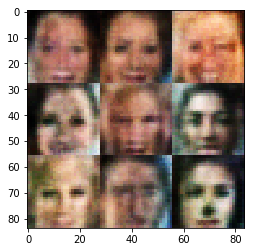

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.5502
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.5456... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.9986
Epoch 1/1... Discriminator Loss: 0.8764... Generator Loss: 1.4089
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 0.9160... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.9810


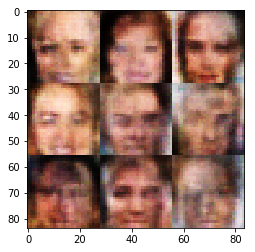

Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.8592
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.9974
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9731


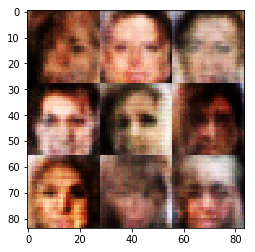

Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.8657
Epoch 1/1... Discriminator Loss: 1.1173... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.2376
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 1.1095
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.3372
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 1.0049
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7886


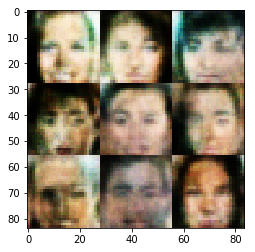

Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 1.1815
Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 1.1379
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.8863


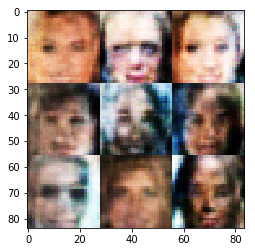

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 1.0988
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.9853
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.9693


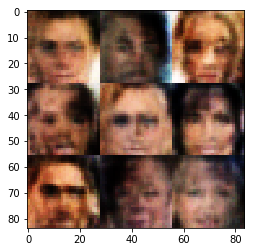

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.9757
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.2164


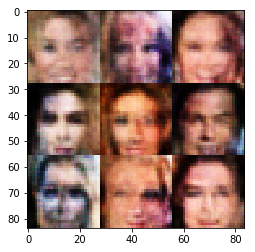

Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.2595
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.0345
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.0506
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.3262
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9400


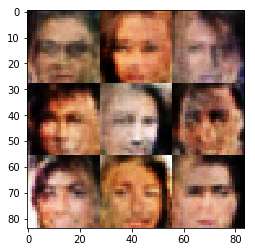

Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.1194
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9472
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.9994
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8476
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 1.2549
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.7759


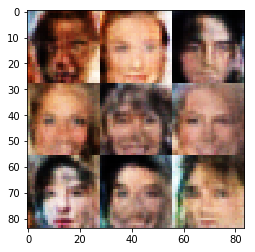

Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.0425
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.2263
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.9551


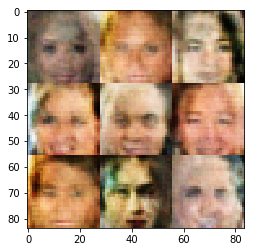

Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9996
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.9750
Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.9413


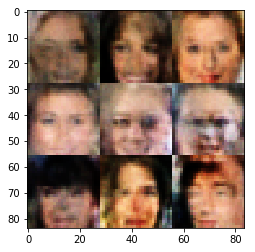

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 1.5097
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 1.1901
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 1.1905
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 1.0035


In [18]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.